In [1]:
import torch
import matplotlib.pyplot as plt
from modelcraft_expedition.models.transformers.vit import (
    PatchEmbed,
    Attention,
    MLP,
    DropPath,
    Block,
    ViT,
)

In [2]:
def plot_attention_map(attention_map, title="Attention Map"):
    """
    Plot an attention map as a heatmap.

    Args:
        attention_map: Tensor of shape [H, N, N] or [N, N]
        title: Title for the plot
    """
    if attention_map.dim() == 3:
        # If we have multiple heads, average them
        attention_map = attention_map.mean(0)

    plt.figure(figsize=(10, 8))
    plt.imshow(attention_map.detach().cpu().numpy(), cmap="viridis")
    plt.colorbar()
    plt.title(title)
    plt.xlabel("Key position")
    plt.ylabel("Query position")
    plt.tight_layout()
    plt.show()

In [3]:
def visualize_patches(image_tensor, patch_size, title="Image Patches"):
    """
    Visualize how an image is divided into patches.

    Args:
        image_tensor: Tensor of shape [1, C, H, W]
        patch_size: Size of each patch
        title: Title for the plot
    """
    # Convert to numpy for visualization
    image = image_tensor.squeeze(0).permute(1, 2, 0).detach().cpu().numpy()

    # Normalize for visualization if needed
    if image.max() > 1.0 or image.min() < 0.0:
        image = (image - image.min()) / (image.max() - image.min())

    h, w, _ = image.shape

    # Create a grid to show patch boundaries
    _, ax = plt.subplots(figsize=(10, 10))
    ax.imshow(image)

    # Draw patch grid
    for i in range(0, h, patch_size):
        ax.axhline(i, color="red", linewidth=1)
    for j in range(0, w, patch_size):
        ax.axvline(j, color="red", linewidth=1)

    ax.set_title(title)
    plt.tight_layout()
    plt.show()

=== Testing PatchEmbed ===
Input shape: torch.Size([2, 3, 224, 224])
Output shape: torch.Size([2, 196, 768])
Expected number of patches: 196
Actual number of patches: 196
Embedding dimension: 768


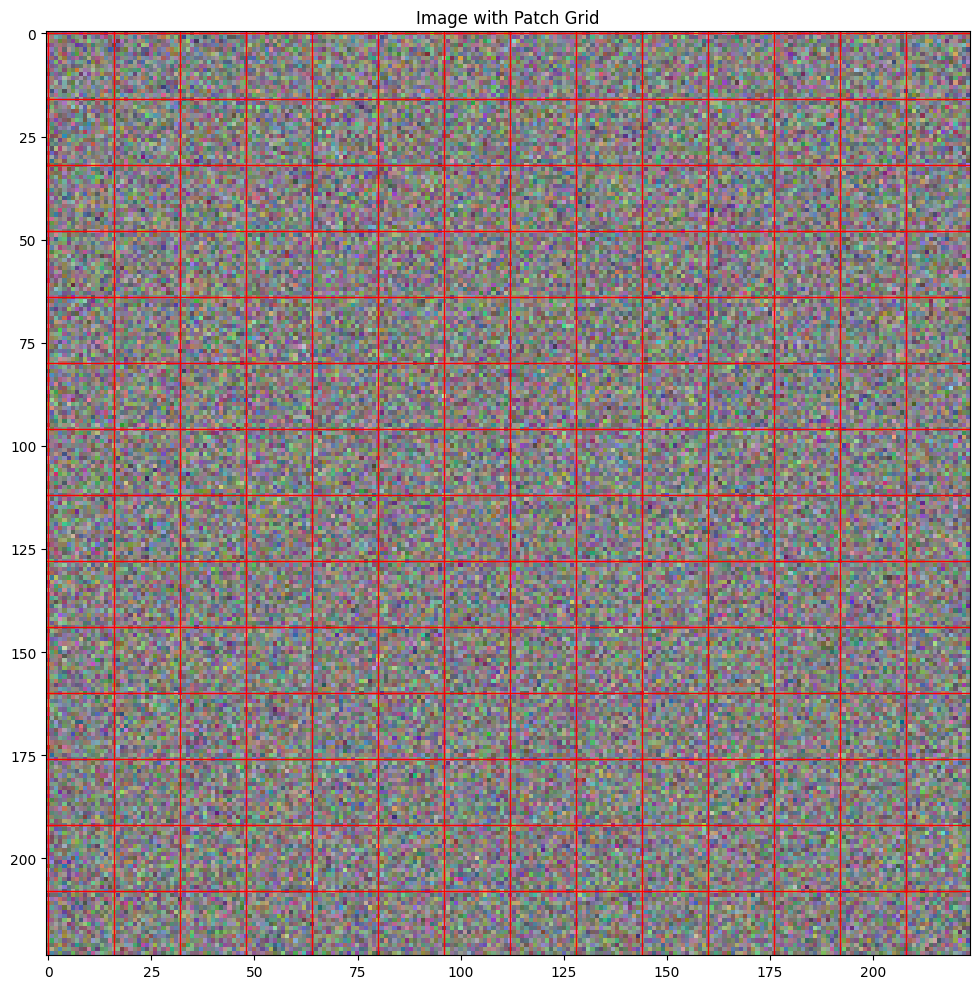

PatchEmbed test passed!



In [4]:
def test_patch_embed():
    """
    Test the PatchEmbed class.
    """
    print("=== Testing PatchEmbed ===")

    # Test parameters
    img_size = 224
    patch_size = 16
    in_channels = 3
    embed_dim = 768

    # Create a sample image
    img = torch.randn(2, in_channels, img_size, img_size)

    # Create patch embedding layer
    patch_embed = PatchEmbed(
        img_size=img_size,
        patch_size=patch_size,
        in_channels=in_channels,
        embed_dim=embed_dim,
    )

    # Compute expected number of patches
    expected_n_patches = (img_size // patch_size) ** 2

    # Forward pass
    embeddings = patch_embed(img)

    # Print results
    print(f"Input shape: {img.shape}")
    print(f"Output shape: {embeddings.shape}")
    print(f"Expected number of patches: {expected_n_patches}")
    print(f"Actual number of patches: {embeddings.shape[1]}")
    print(f"Embedding dimension: {embeddings.shape[2]}")

    # Visualize patches for the first image
    visualize_patches(img[0:1], patch_size, "Image with Patch Grid")

    # Verify that the output shape is correct
    assert embeddings.shape == (2, expected_n_patches, embed_dim), (
        "Output shape is incorrect"
    )
    print("PatchEmbed test passed!")
    print()


test_patch_embed()

=== Testing Attention ===
Input shape: torch.Size([2, 10, 768])
Output shape: torch.Size([2, 10, 768])
Number of heads: 12
Head dimension: 64


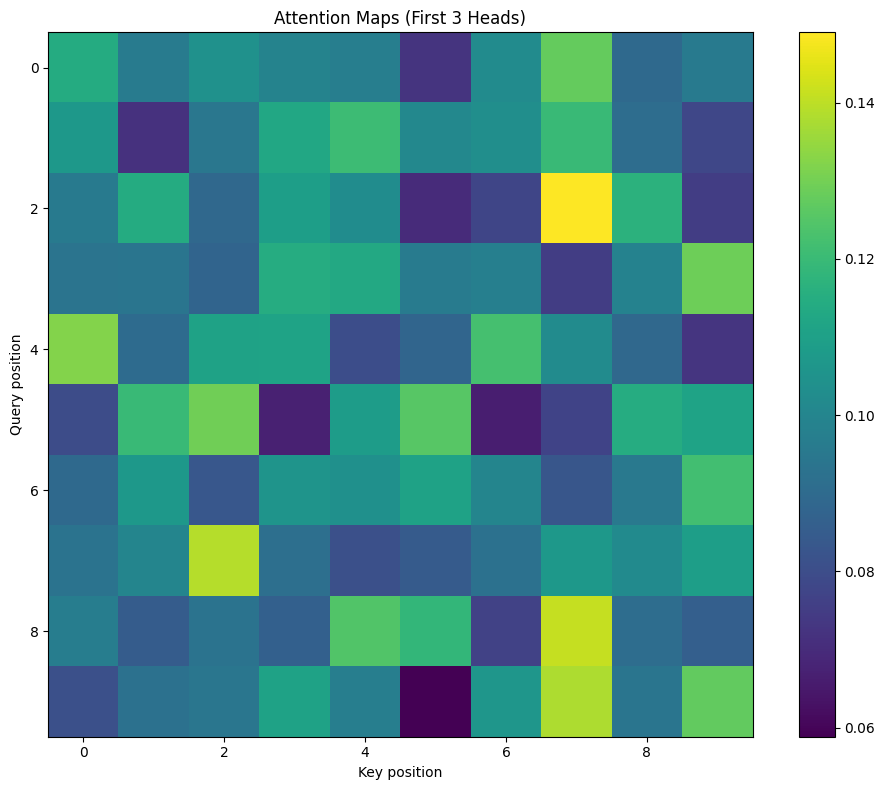

Attention test passed!



In [5]:
def test_attention():
    """
    Test the Attention class.
    """
    print("=== Testing Attention ===")

    # Test parameters
    batch_size = 2
    seq_length = 10
    embed_dim = 768
    num_heads = 12

    # Create input tensor
    x = torch.randn(batch_size, seq_length, embed_dim)

    # Create attention layer
    attention = Attention(
        dim=embed_dim, num_heads=num_heads, qkv_bias=True, attn_drop=0.1, proj_drop=0.1
    )

    # Forward pass
    output = attention(x)

    # Print results
    print(f"Input shape: {x.shape}")
    print(f"Output shape: {output.shape}")
    print(f"Number of heads: {num_heads}")
    print(f"Head dimension: {embed_dim // num_heads}")

    # Extract attention weights for visualization
    # We need to run the forward pass again to capture intermediate values
    with torch.no_grad():
        # Get QKV projections
        qkv = attention.qkv(x).reshape(
            batch_size, seq_length, 3, num_heads, embed_dim // num_heads
        )
        qkv = qkv.permute(2, 0, 3, 1, 4)
        q, k, v = qkv.unbind(0)

        # Compute attention scores
        attn = (q @ k.transpose(-2, -1)) * attention.scale
        attn = attn.softmax(dim=-1)

    # Visualize attention map for the first batch and first few heads
    plot_attention_map(attn[0, :3], "Attention Maps (First 3 Heads)")

    # Verify that the output shape is correct
    assert output.shape == x.shape, "Output shape should match input shape"
    print("Attention test passed!")
    print()


test_attention()

In [6]:
def test_mlp():
    """
    Test the MLP class.
    """
    print("=== Testing MLP ===")

    # Test parameters
    batch_size = 2
    seq_length = 10
    in_features = 768
    hidden_features = 3072  # 4 * in_features

    # Create input tensor
    x = torch.randn(batch_size, seq_length, in_features)

    # Create MLP layer
    mlp = MLP(in_features=in_features, hidden_features=hidden_features, drop=0.1)

    # Forward pass
    output = mlp(x)

    # Print results
    print(f"Input shape: {x.shape}")
    print(f"Output shape: {output.shape}")
    print(f"MLP hidden dimension: {hidden_features}")

    # Verify that the output shape is correct
    assert output.shape == x.shape, "Output shape should match input shape"
    print("MLP test passed!")
    print()


test_mlp()

=== Testing MLP ===
Input shape: torch.Size([2, 10, 768])
Output shape: torch.Size([2, 10, 768])
MLP hidden dimension: 3072
MLP test passed!



In [7]:
def test_drop_path():
    """
    Test the DropPath class.
    """
    print("=== Testing DropPath ===")

    # Test parameters
    batch_size = 1000
    drop_prob = 0.2

    # Create input tensor
    x = torch.ones(batch_size, 10, 10)

    # Create DropPath layer
    drop_path = DropPath(drop_prob=drop_prob)

    # Set to training mode
    drop_path.train()

    # Forward pass
    output = drop_path(x)

    # Calculate the ratio of dropped paths
    zeros_ratio = (output.sum(dim=(1, 2)) == 0).float().mean().item()

    # Print results
    print(f"Input shape: {x.shape}")
    print(f"Output shape: {output.shape}")
    print(f"Drop probability: {drop_prob}")
    print(f"Actual drop ratio: {zeros_ratio:.4f}")

    # Set to evaluation mode
    drop_path.eval()
    eval_output = drop_path(x)

    # Verify that no dropping occurs during evaluation
    assert torch.allclose(eval_output, x), "No dropping should occur during evaluation"
    print("DropPath test passed!")
    print()


test_drop_path()

=== Testing DropPath ===
Input shape: torch.Size([1000, 10, 10])
Output shape: torch.Size([1000, 10, 10])
Drop probability: 0.2
Actual drop ratio: 0.1850
DropPath test passed!



In [8]:
def test_block():
    """
    Test the Transformer Block.
    """
    print("=== Testing Transformer Block ===")

    # Test parameters
    batch_size = 2
    seq_length = 10
    embed_dim = 768
    num_heads = 12
    mlp_ratio = 4.0

    # Create input tensor
    x = torch.randn(batch_size, seq_length, embed_dim)

    # Create Block
    block = Block(
        dim=embed_dim,
        num_heads=num_heads,
        mlp_ratio=mlp_ratio,
        qkv_bias=True,
        drop=0.1,
        attn_drop=0.1,
        drop_path=0.1,
    )

    # Forward pass
    output = block(x)

    # Print results
    print(f"Input shape: {x.shape}")
    print(f"Output shape: {output.shape}")
    print("Block parameters:")
    print(f"  - Embedding dimension: {embed_dim}")
    print(f"  - Number of heads: {num_heads}")
    print(f"  - MLP ratio: {mlp_ratio}")
    print(f"  - MLP hidden dimension: {int(embed_dim * mlp_ratio)}")

    # Verify that the output shape is correct
    assert output.shape == x.shape, "Output shape should match input shape"
    print("Block test passed!")
    print()


test_block()

=== Testing Transformer Block ===
Input shape: torch.Size([2, 10, 768])
Output shape: torch.Size([2, 10, 768])
Block parameters:
  - Embedding dimension: 768
  - Number of heads: 12
  - MLP ratio: 4.0
  - MLP hidden dimension: 3072
Block test passed!



In [9]:
def test_vit():
    """
    Test the complete Vision Transformer model.
    """
    print("=== Testing Vision Transformer (ViT) ===")

    # Test parameters
    batch_size = 2
    img_size = 224
    patch_size = 16
    in_channels = 3
    num_classes = 1000

    # Create a sample image
    img = torch.randn(batch_size, in_channels, img_size, img_size)

    # Create ViT model
    vit = ViT(
        img_size=img_size,
        patch_size=patch_size,
        in_channels=in_channels,
        num_classes=num_classes,
        embed_dim=768,
        depth=12,
        num_heads=12,
        mlp_ratio=4.0,
        qkv_bias=True,
        drop_rate=0.1,
        attn_drop_rate=0.0,
        drop_path_rate=0.1,
    )

    # Forward pass
    logits = vit(img)

    # Extract features
    features = vit.forward_features(img)

    # Print results
    print(f"Input shape: {img.shape}")
    print(f"Output logits shape: {logits.shape}")
    print(f"Feature vector shape: {features.shape}")
    print("Model parameters:")
    print(f"  - Image size: {img_size}")
    print(f"  - Patch size: {patch_size}")
    print(f"  - Number of patches: {(img_size // patch_size) ** 2}")
    print(f"  - Embedding dimension: {vit.patch_embed.proj.out_channels}")
    print(f"  - Number of transformer layers: {len(vit.blocks)}")
    print(f"  - Number of attention heads: {vit.blocks[0].attn.num_heads}")
    print(
        f"  - MLP ratio: {vit.blocks[0].mlp.fc1.out_features / vit.blocks[0].mlp.fc1.in_features}"
    )

    # Count parameters
    total_params = sum(p.numel() for p in vit.parameters())
    print(f"Total parameters: {total_params:,}")

    # Verify shapes
    assert logits.shape == (batch_size, num_classes), "Output logits shape is incorrect"
    assert features.shape == (batch_size, vit.patch_embed.proj.out_channels), (
        "Feature vector shape is incorrect"
    )
    print("ViT test passed!")
    print()


test_vit()

=== Testing Vision Transformer (ViT) ===
Input shape: torch.Size([2, 3, 224, 224])
Output logits shape: torch.Size([2, 1000])
Feature vector shape: torch.Size([2, 768])
Model parameters:
  - Image size: 224
  - Patch size: 16
  - Number of patches: 196
  - Embedding dimension: 768
  - Number of transformer layers: 12
  - Number of attention heads: 12
  - MLP ratio: 4.0
Total parameters: 86,567,656
ViT test passed!



=== Testing ViT Inference ===
Top 5 predictions:
  1. Class 8: 0.1517
  2. Class 3: 0.1214
  3. Class 0: 0.1130
  4. Class 9: 0.1099
  5. Class 7: 0.0962


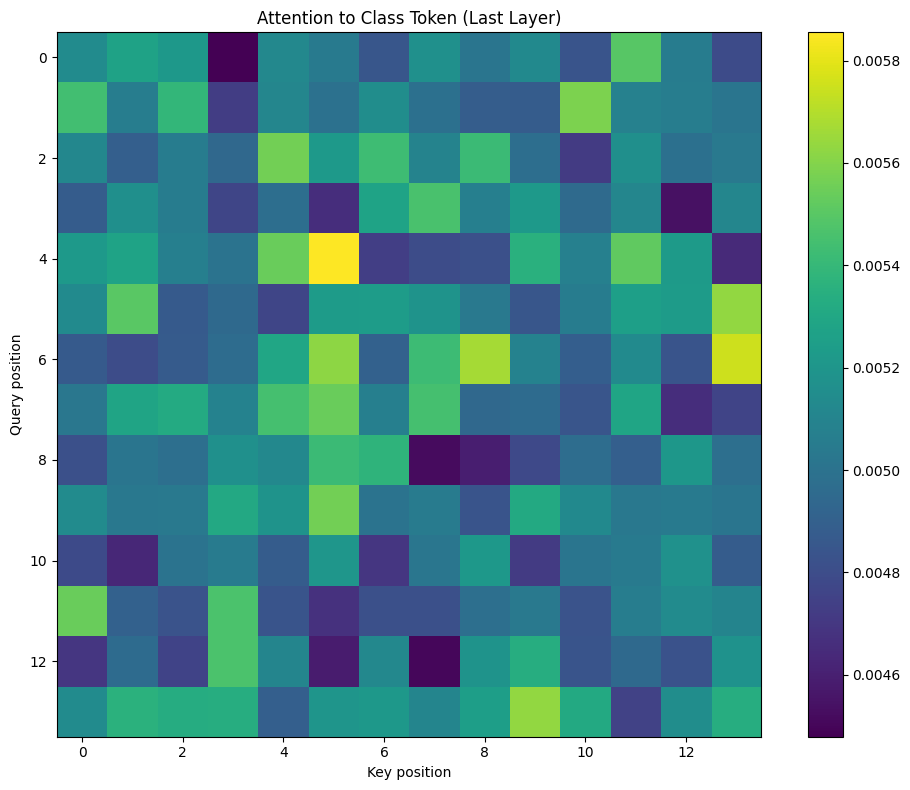

ViT inference test completed!



In [10]:
def test_vit_inference():
    """
    Test ViT inference with visualization.
    """
    print("=== Testing ViT Inference ===")

    # Create a more realistic test image (random noise in this case)
    img = torch.randn(1, 3, 224, 224)

    # Create a smaller ViT model for faster testing
    vit_mini = ViT(
        img_size=224,
        patch_size=16,
        in_channels=3,
        num_classes=10,  # Smaller number of classes
        embed_dim=192,  # Smaller embedding dimension
        depth=4,  # Fewer transformer layers
        num_heads=3,  # Fewer attention heads
        mlp_ratio=4.0,
        qkv_bias=True,
        drop_rate=0.0,
        attn_drop_rate=0.0,
        drop_path_rate=0.0,
    )

    # Set to evaluation mode
    vit_mini.eval()

    # Forward pass with no gradient computation
    with torch.no_grad():
        logits = vit_mini(img)
        probs = torch.nn.functional.softmax(logits, dim=-1)

    # Print top predictions
    values, indices = torch.topk(probs[0], 5)
    print("Top 5 predictions:")
    for i, (idx, prob) in enumerate(zip(indices.tolist(), values.tolist())):
        print(f"  {i + 1}. Class {idx}: {prob:.4f}")

    # Visualize attention from the last layer
    # We need to extract attention weights from a forward pass
    with torch.no_grad():
        # Get patch embeddings
        x = vit_mini.patch_embed(img)

        # Add class token
        cls_token = vit_mini.cls_token.expand(img.shape[0], -1, -1)
        x = torch.cat((cls_token, x), dim=1)

        # Add position embeddings
        x = x + vit_mini.pos_embed
        x = vit_mini.pos_drop(x)

        # Process through transformer blocks except the last one
        for i in range(len(vit_mini.blocks) - 1):
            x = vit_mini.blocks[i](x)

        # For the last block, extract attention weights
        last_block = vit_mini.blocks[-1]

        # Get normalized input
        norm_x = last_block.norm1(x)

        # Get QKV projections
        qkv = (
            last_block.attn.qkv(norm_x)
            .reshape(
                img.shape[0], -1, 3, last_block.attn.num_heads, last_block.attn.head_dim
            )
            .permute(2, 0, 3, 1, 4)
        )
        q, k, v = qkv.unbind(0)

        # Compute attention scores
        attn = (q @ k.transpose(-2, -1)) * last_block.attn.scale
        attn = attn.softmax(dim=-1)

    # Visualize attention to the class token
    cls_attn = attn[0, :, 0, 1:]  # [num_heads, num_patches]

    # Reshape to match the spatial dimensions of the image
    patch_size = vit_mini.patch_embed.patch_size
    num_patches_per_side = img.shape[-1] // patch_size
    cls_attn_map = cls_attn.reshape(
        last_block.attn.num_heads, num_patches_per_side, num_patches_per_side
    )

    # Plot attention map
    plot_attention_map(cls_attn_map, "Attention to Class Token (Last Layer)")

    print("ViT inference test completed!")
    print()


test_vit_inference()